Kaggle Competition

# Abstract

It is very important for bank to identify which customers are satisfied or unstaisfied with their services. Santander Bank made some of the data public and asked us to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

**Competition: -** From frontline support teams to C-suites, customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

Santander Bank is asking Kagglers to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

### Dependencies

In [1]:
# pip install numpy

In [2]:
# pip install pandas

In [3]:
# pip install matplotlib

In [4]:
# pip install seaborn

In [5]:
# pip install scikit-learn

# Importing Libraries And Datasets

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# Load the training data
train = pd.read_csv( "https://raw.githubusercontent.com/sumedhtelang/Kaggle_santander_customer_satisfaction/master/data/train.csv")

# Load the testing data
test = pd.read_csv( "https://raw.githubusercontent.com/sumedhtelang/Kaggle_santander_customer_satisfaction/master/data/test.csv")

# Exploratory Data Analysis

**num_var4 :** how many bank account/loan/any other form of account customers have

In below visualization we can see that majority of the customers have only 1 type of product with santander bank

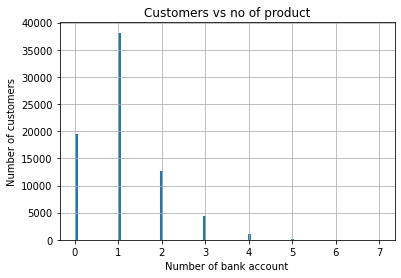

In [7]:
train.num_var4.hist(bins=100)
plt.xlabel('Number of bank account')
plt.ylabel('Number of customers')
plt.title('Customers vs no of product')
plt.show()

Histogram of customers with no of products with santander bank

Here we can see that majority of unhappy customers have less products with the bank

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


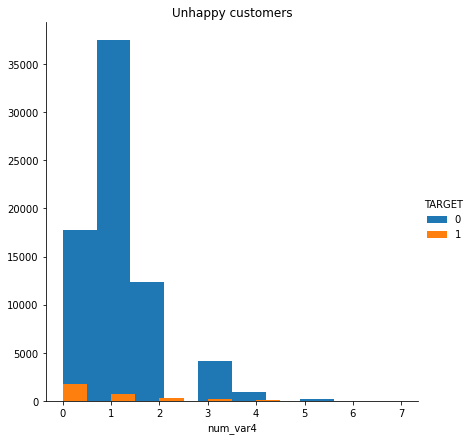

In [8]:
import seaborn as sns
# Let's look at the density of the of happy/unhappy customers in function of the number of bank products
sns.FacetGrid(train, hue="TARGET", size=6) \
   .map(plt.hist, "num_var4") \
   .add_legend()
plt.title('Unhappy customers')
plt.show()

Number of customers unhappy and number of products they have with bank

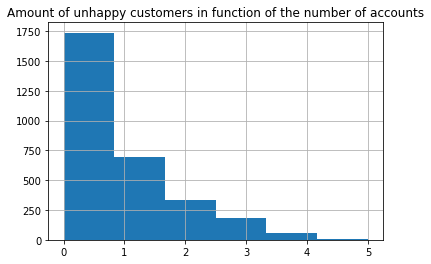

In [9]:
train[train.TARGET==1].num_var4.hist(bins=6)
plt.title('Amount of unhappy customers in function of the number of accounts');

One of the most important feature var15. According to a Kaggle discussion board var15 is the age of the customer.

Average age of the customer in the bank is around 33

In [10]:
train['var15'].describe()

count    76020.000000
mean        33.212865
std         12.956486
min          5.000000
25%         23.000000
50%         28.000000
75%         40.000000
max        105.000000
Name: var15, dtype: float64

Histogram of distribution age of customers

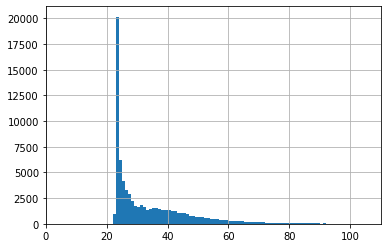

In [11]:
#Looks more normal, plot the histogram
train['var15'].hist(bins=100);

Here in this kernel density plot we can see that majority of unhappy customers are older.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


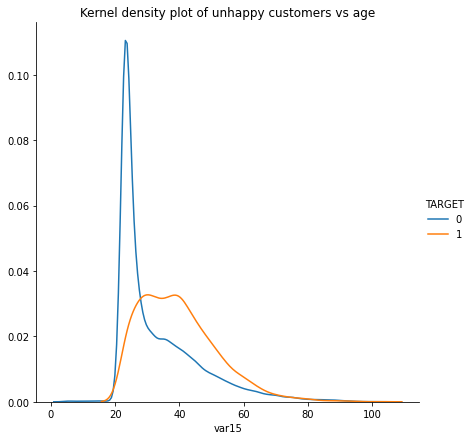

In [12]:
# Let's look at the density of the age of happy/unhappy customers
sns.FacetGrid(train, hue="TARGET", size=6) \
   .map(sns.kdeplot, "var15") \
   .add_legend()
plt.title('Kernel density plot of unhappy customers vs age');

saldo_varX => saldo => balance

Here we can see that most customers have accountbalance between 0 to 5,00,000

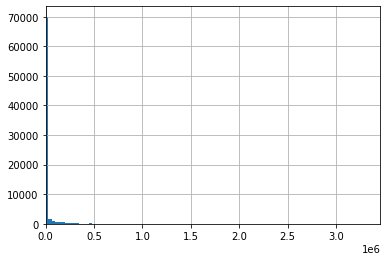

In [13]:
train.saldo_var30.hist(bins=100)
plt.xlim(0, train.saldo_var30.max());

var38:- mortgage value with bank

Scatter plot of age of customer and mortgage value the have at bank

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


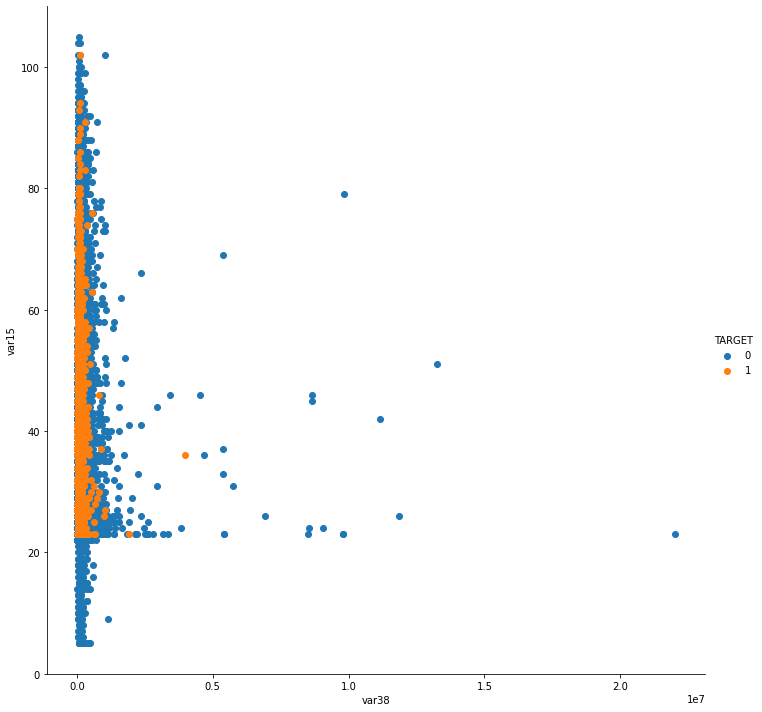

In [14]:
sns.FacetGrid(train, hue="TARGET", size=10) \
   .map(plt.scatter, "var38", "var15") \
   .add_legend()

- Above plot suggest we split up var38 into two variables
- var38mc == 1 when var38 has the most common value and 0 otherwise
- logvar38 is log transformed feature when var38mc is 0, zero otherwise

In [15]:
train['var38mc'] = np.isclose(train.var38, 117310.979016)
train['logvar38'] = train.loc[~train['var38mc'], 'var38'].map(np.log)
train.loc[train['var38mc'], 'logvar38'] = 0

In [16]:
#Check for null values
print('Number of nan in var38mc', train['var38mc'].isnull().sum())
print('Number of nan in logvar38',train['logvar38'].isnull().sum())

Number of nan in var38mc 0
Number of nan in logvar38 0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


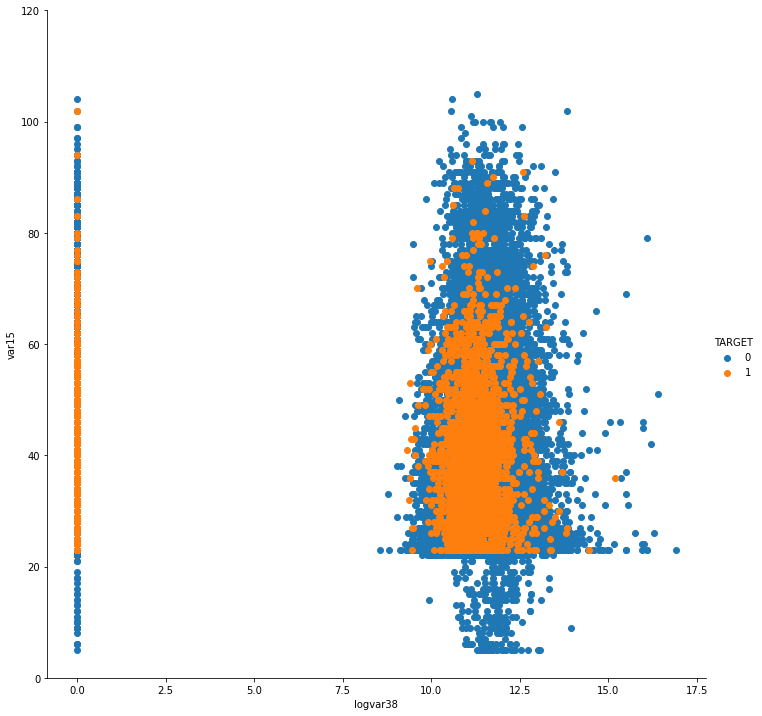

In [17]:
sns.FacetGrid(train, hue="TARGET", size=10) \
   .map(plt.scatter, "logvar38", "var15") \
   .add_legend()
plt.ylim([0,120]); # Age must be positive ;-

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


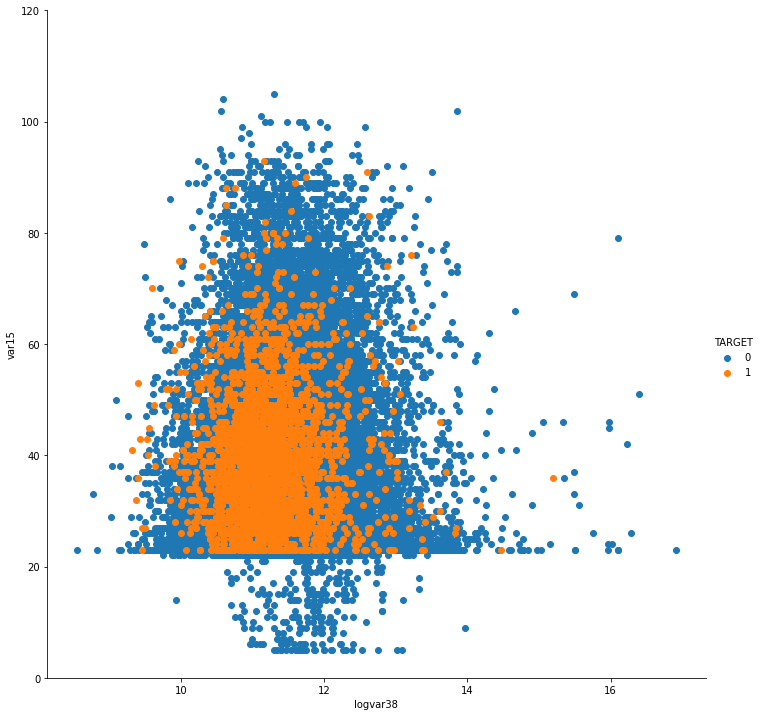

In [18]:
# Exclude most common value for var38 
sns.FacetGrid(train[~train.var38mc], hue="TARGET", size=10) \
   .map(plt.scatter, "logvar38", "var15") \
   .add_legend()
plt.ylim([0,120]);

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


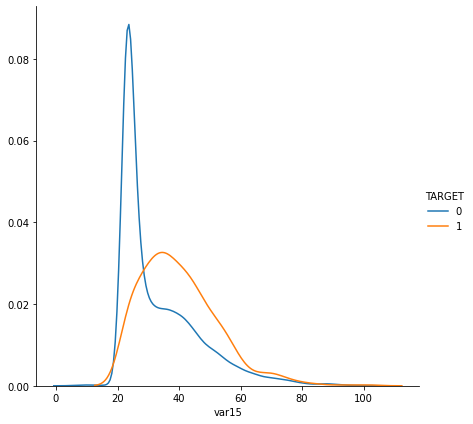

In [19]:
sns.FacetGrid(train[train.var38mc], hue="TARGET", size=6) \
   .map(sns.kdeplot, "var15") \
   .add_legend();

In [20]:
y_train = train.TARGET
X_train = train.drop(['ID','TARGET', 'var38mc', 'logvar38'], axis=1)

id_test = test['ID']
X_test_pred = test.drop(['ID'], axis=1)

# length of dataset
len_train = len(X_train)
len_test  = len(X_test_pred)

In [21]:
X_train.columns

Index(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3', 'imp_op_var40_ult1',
       ...
       'saldo_medio_var29_ult3', 'saldo_medio_var33_hace2',
       'saldo_medio_var33_hace3', 'saldo_medio_var33_ult1',
       'saldo_medio_var33_ult3', 'saldo_medio_var44_hace2',
       'saldo_medio_var44_hace3', 'saldo_medio_var44_ult1',
       'saldo_medio_var44_ult3', 'var38'],
      dtype='object', length=369)

# Feature Importance

Chi Square test for most important features.

In [22]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale

p = 3

X_bin = Binarizer().fit_transform(scale(X_train))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y_train)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(X_train, y_train)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(X_train.columns) if chi2_selected[i]]
print('Chi2 selected {} features {}.'.format(chi2_selected.sum(),
   chi2_selected_features))

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(X_train.columns) if f_classif_selected[i]]
print('F_classif selected {} features {}.'.format(f_classif_selected.sum(),
   f_classif_selected_features))

selected = chi2_selected & f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(X_train.columns, selected) if s]
print (features)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Chi2 selected 12 features ['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var5', 'num_var8_0', 'num_var30_0', 'num_var30', 'num_var42', 'saldo_var30', 'var36', 'num_meses_var5_ult3'].
F_classif selected 12 features ['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var4', 'num_var5', 'num_var8_0', 'num_var30', 'num_var35', 'num_var42', 'var36', 'num_meses_var5_ult3'].
Chi2 & F_classif selected 10 features
['var15', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var5', 'num_var8_0', 'num_var30', 'num_var42', 'var36', 'num_meses_var5_ult3']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [ 21  22  56  57  58  59  80  84  85 131 132 133 134 155 161 162 179 180
 189 192 220 222 234 238 244 248 261 262 303 307 315 319 327 349] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Random Forest Classifier to check most important features.

In [23]:
y_train.value_counts() / float(y_train.size)

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

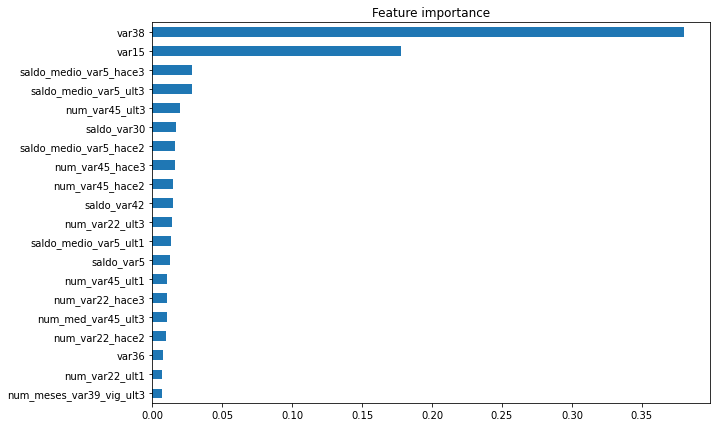

In [25]:
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_imp.sort_values(inplace=True)
ax = feat_imp.tail(20).plot(kind='barh', figsize=(10,7), title='Feature importance')

In [26]:
train.isnull().count()

ID                         76020
var3                       76020
var15                      76020
imp_ent_var16_ult1         76020
imp_op_var39_comer_ult1    76020
                           ...  
saldo_medio_var44_ult3     76020
var38                      76020
TARGET                     76020
var38mc                    76020
logvar38                   76020
Length: 373, dtype: int64

### Correlation Matrix of Important Features Selected from chi-square test

In [27]:
X_sel = train[features+['TARGET']]

In [28]:
cor_mat = X_sel.corr()

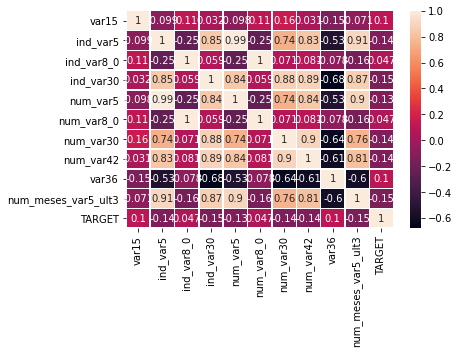

In [29]:
f, ax = plt.subplots()
sns.heatmap(cor_mat,linewidths=.5, ax=ax, annot=True);

# Model Building For Prediction

In [30]:
clf = xgb.XGBClassifier(missing=np.nan, 
                        max_depth=5, 
                        n_estimators=560, 
                        learning_rate=0.02, 
                        nthread=4, 
                        subsample=0.7, 
                        colsample_bytree=0.7, 
                        seed=4242)

In [31]:
X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.3)

In [32]:
clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.80389
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.80613
[2]	validation_0-auc:0.80728
[3]	validation_0-auc:0.80893
[4]	validation_0-auc:0.80843
[5]	validation_0-auc:0.81855
[6]	validation_0-auc:0.82108
[7]	validation_0-auc:0.82167
[8]	validation_0-auc:0.82189
[9]	validation_0-auc:0.82479
[10]	validation_0-auc:0.82451
[11]	validation_0-auc:0.82416
[12]	validation_0-auc:0.82220
[13]	validation_0-auc:0.82421
[14]	validation_0-auc:0.82406
[15]	validation_0-auc:0.82250
[16]	validation_0-auc:0.82134
[17]	validation_0-auc:0.81807
[18]	validation_0-auc:0.82000
[19]	validation_0-auc:0.81801
[20]	validation_0-auc:0.81935
[21]	validation_0-auc:0.82251
[22]	validation_0-auc:0.82269
[23]	validation_0-auc:0.82455
[24]	validation_0-auc:0.82272
[25]	validation_0-auc:0.82465
[26]	validation_0-auc:0.82558
[27]	validation_0-auc:0.82660
[28]	validation_0-auc:0.82664
[29]	validation_0-auc:0.82756
[30]	validation_0-auc:0.82795
[31]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=560, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=4242, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=4242, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [33]:
print('Overall AUC:', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])) 

Overall AUC: 0.8695287262904079


In [34]:
y_pred= clf.predict_proba(X_test_pred)[:,1]

In [35]:
submission = pd.DataFrame({"ID":id_test, "TARGET":y_pred})
submission.to_csv("result/submission1.csv", index=False)

Attempt of randomize grid search

In [36]:
# from sklearn.model_selection import GridSearchCV
# parameters = {'max_depth': [6,7,8,9],
#               'n_estimators':[560, 580, 600],
#               'learning_rate':[0.02, 0.03, 0.04, 0.05], 
#               'nthread':[4,5,6,7]}

# xgb_grid = GridSearchCV(xgb.XGBClassifier(),parameters,cv = 3,n_jobs = 5,verbose=True)

# xgb_grid.fit(X_train,y_train)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

# Summary

1. https://www.kaggle.com/zfturbo/to-the-top-v3

This is one the most popular public notebook written in R which has many upvotes. The model removed all the constant columns from the dataset which is the main approach because of which the accuracy is pretty good. Instead of removing those columns as it is a bank data and almost all the columns are important for prediction of unsatisfied customer i used all the columns and did extra hyperparameter tuning in the xgboost classifier to achieve more accuracy. Also it had no feature importance to identify which are the most important features in the dataset which i was able to calculate using chi square test and random forest classifier feature importance. 

# Conclusion

After trying various machine learning models I can conclude that XGBoost Classifier is best for identifying the unsatisfies customers with good predictive probability score of 0.83957 after hyperparameter tuning. 

**Kaggle Competition Leaderboard Result :-**

- Public Score : 0.83957
- Private Score : 0.82603

# Citation

1. https://xgboost.readthedocs.io/en/latest/parameter.html

2. https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde

3. https://www.kaggle.com/c/santander-customer-satisfaction/discussion/19291#110414

4. https://www.youtube.com/watch?v=AvWfL1Us3Kg&ab_channel=DataMites

5. https://www.kaggle.com/c/santander-customer-satisfaction/discussion/19895

6. https://www.kaggle.com/cast42/random-forest


**Contribution Statement: -** I have referred above code(cited) and kaggle discussion board to identify which variables indicate which value and also used the base code for chi square test. Remaining all code is written by me.


Copyright (c) 2020 sumedhtelang

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.